# 2D Pose Estimation

In [17]:
%matplotlib inline

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Add,
    Input,
    ReLU,
    UpSampling2D,
    BatchNormalization
)
import math

## Build the dataset

![Dataset Joints](res/joints.png)

In [2]:
IMG_FOLDER = 'images'
release = loadmat('mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')['RELEASE']

In [3]:
data = []
d_c = 0

# Code adapted from: https://github.com/mitmul/deeppose/blob/master/datasets/mpii_dataset.py
for i, anno in enumerate(release['annolist'][0, 0][0]):

    img_fn = anno['image']['name'][0, 0][0]
    head_rect = []
    
    if release['img_train'][0,0][0][i] == 0:
        d_c += 1

    if 'annopoints' in str(anno['annorect'].dtype):
        annopoints = anno['annorect']['annopoints'][0]
        head_x1s = anno['annorect']['x1'][0]
        head_y1s = anno['annorect']['y1'][0]
        head_x2s = anno['annorect']['x2'][0]
        head_y2s = anno['annorect']['y2'][0]

        for annopoint, head_x1, head_y1, head_x2, head_y2 in zip(annopoints, head_x1s, head_y1s, 
                                                                 head_x2s, head_y2s):
            if annopoint != []:
                head_rect = [float(head_x1[0, 0]),
                             float(head_y1[0, 0]),
                             float(head_x2[0, 0]),
                             float(head_y2[0, 0])]

                # joint coordinates
                annopoint = annopoint['point'][0, 0]
                j_id = [j_i[0, 0] for j_i in annopoint['id'][0]]
                x = [x[0, 0] for x in annopoint['x'][0]]
                y = [y[0, 0] for y in annopoint['y'][0]]
                joint_pos = {}
                for _j_id, (_x, _y) in zip(j_id, zip(x, y)):
                    joint_pos[_j_id] = [float(_x), float(_y)]
                
                if len(joint_pos) != 16:
                    for i in range(16):
                        if i not in joint_pos:
                            joint_pos[i] = [-1,-1]
                            
                data.append({'filename': img_fn,
                     'head_rect': head_rect,
                     'joint_pos': joint_pos
                    })
                    

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


### Split into train-test

__NOTE__: We ignore the default train - test annotations because of examples with missing joint annotations. We first get the annotated examples, and then perform the train-test split.

In [4]:
train, test = train_test_split(data, test_size=0.1)
del data, release

Test examples are not annotated, and some training examples (671) miss joint annotations.

In [5]:
len(train), len(test)

(25994, 2889)

#### Visualize some train data

In [6]:
joint_unions = [(8, 12), (12, 11), (11, 10), (8, 13), (13, 14), (14, 15), (8, 7), (7, 6), (6, 2), \
                (2, 1), (1, 0), (6, 3), (3, 4), (4, 5)]

def plot_skeleton(data_dict):
    """
    Input:
        - data_dict: dictionary with fields ['filename' or 'img', 'head_rect', 'joint_pos']
    Output:
        - plot of the image with the joint skeletons drawn above
    """
    is_crop = False
    
    if 'filename' in data_dict.keys():
        img = mpimg.imread(f'{IMG_FOLDER}/{data_dict["filename"]}')
        plt.figure(figsize=(16,16))
        plt.imshow(img)
    elif 'img' in data_dict.keys():
        img = data_dict['img']
        is_crop = True
        
    if is_crop:
        plt.figure(figsize=(6,6))
        plt.imshow(img)

    plt.plot([data_dict['head_rect'][0], data_dict['head_rect'][0]], 
             [data_dict['head_rect'][1], data_dict['head_rect'][3]],
             c='blue', lw=3)
    plt.plot([data_dict['head_rect'][0], data_dict['head_rect'][2]], 
             [data_dict['head_rect'][3], data_dict['head_rect'][3]],
             c='blue', lw=3)
    plt.plot([data_dict['head_rect'][2], data_dict['head_rect'][2]], 
             [data_dict['head_rect'][1], data_dict['head_rect'][3]],
             c='blue', lw=3)
    plt.plot([data_dict['head_rect'][0], data_dict['head_rect'][2]], 
             [data_dict['head_rect'][1], data_dict['head_rect'][1]],
             c='blue', lw=3)

    for o, t in joint_unions:
        if data_dict['joint_pos'][o][0] == -1 or data_dict['joint_pos'][o][1] == -1 \
           or data_dict['joint_pos'][t][0] == -1 or data_dict['joint_pos'][t][1] == -1:
            continue
            
        plt.plot([data_dict['joint_pos'][o][0], data_dict['joint_pos'][t][0]], 
                 [data_dict['joint_pos'][o][1], data_dict['joint_pos'][t][1]],
                 lw=3)

    plt.axis('off')
    

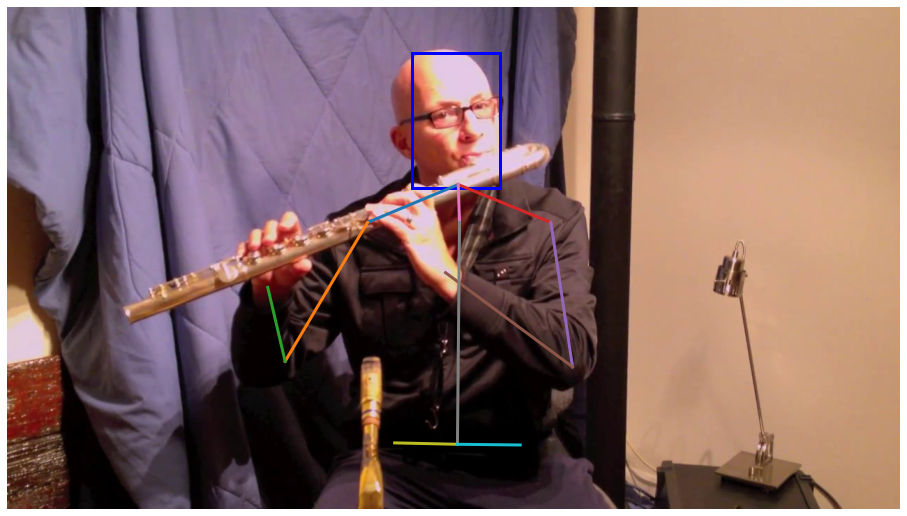

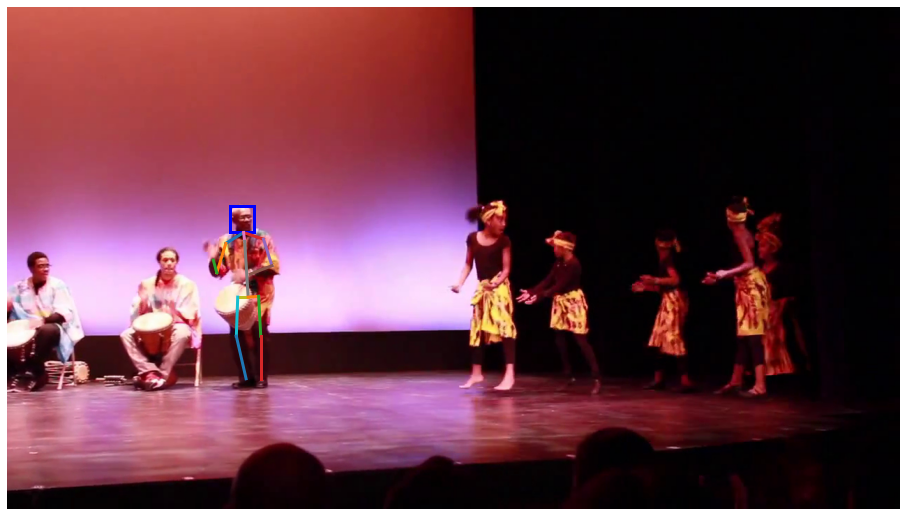

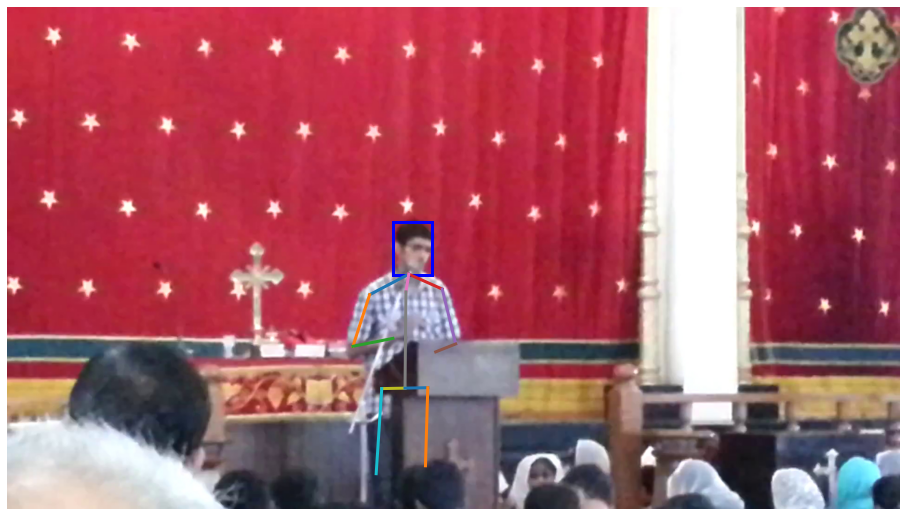

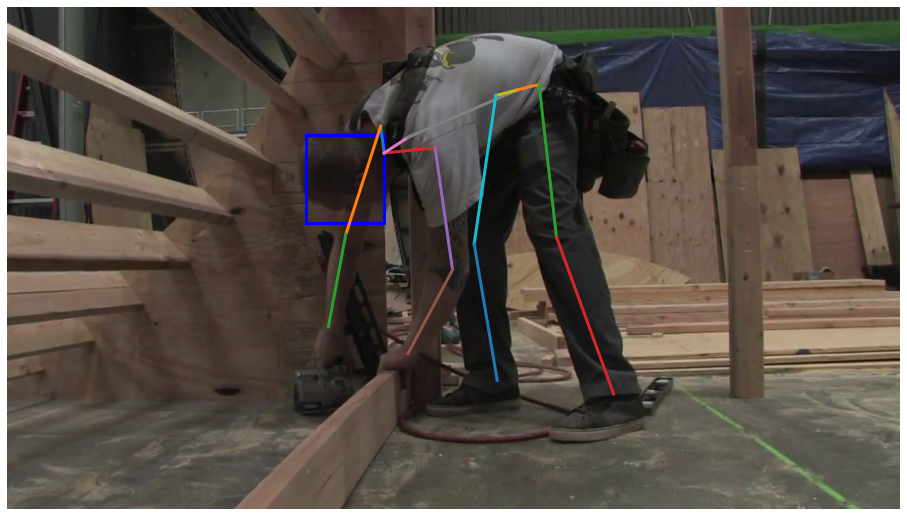

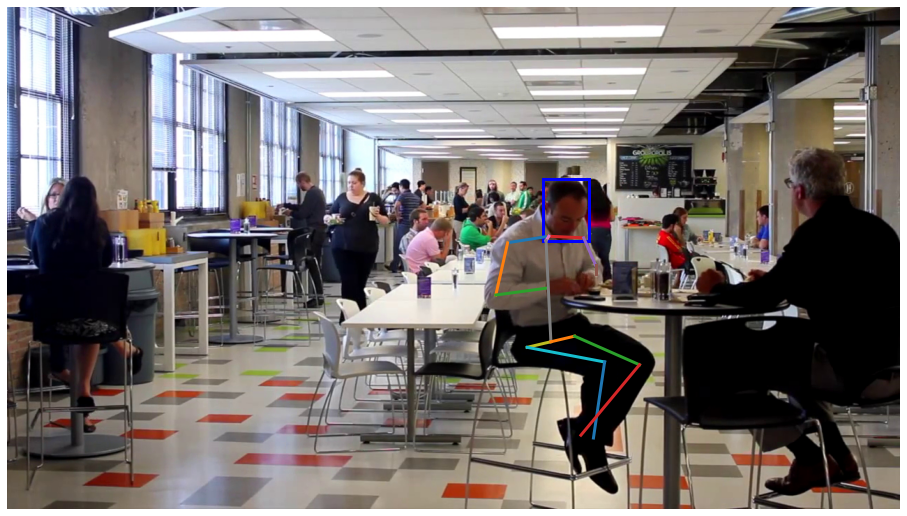

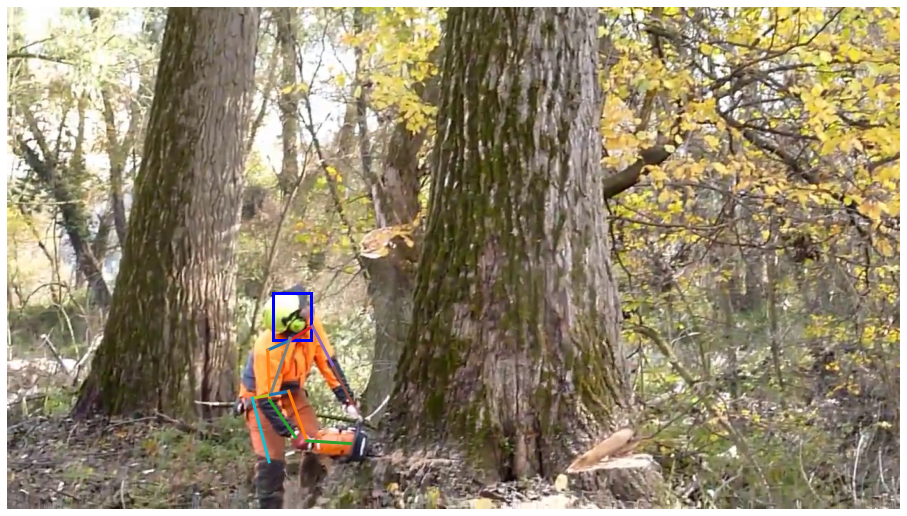

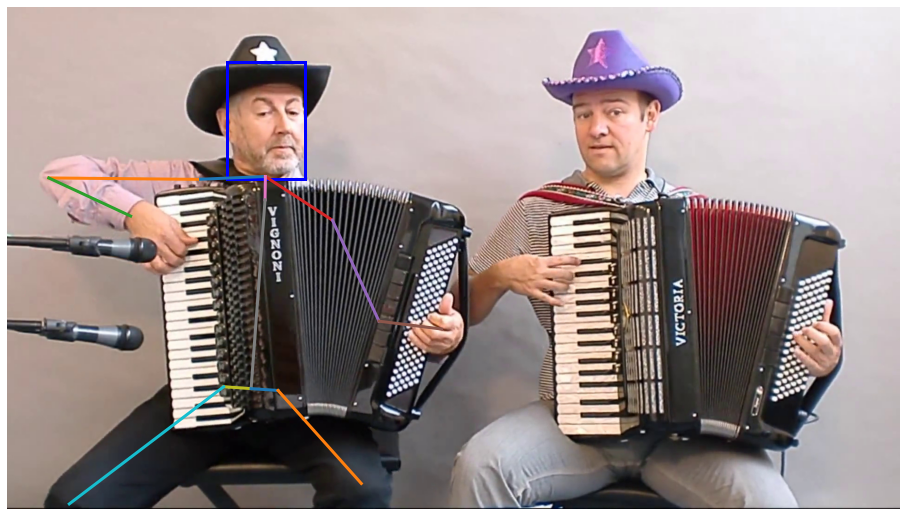

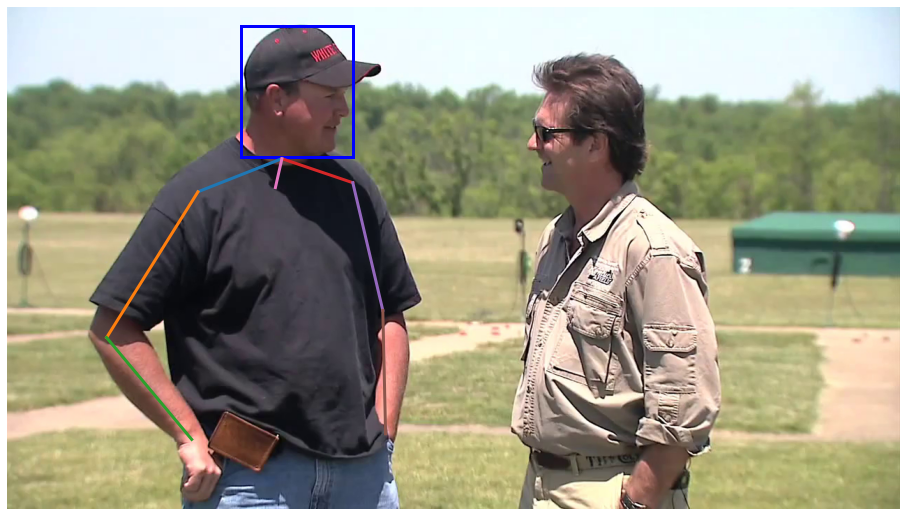

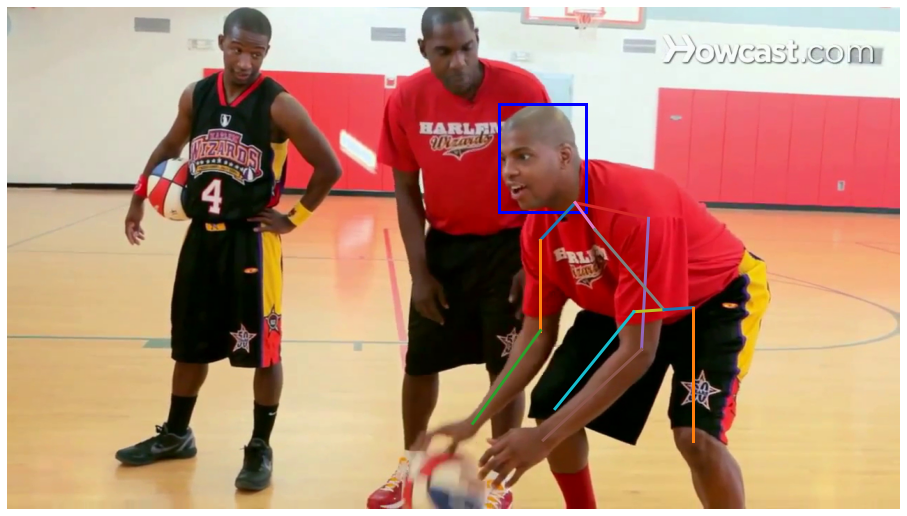

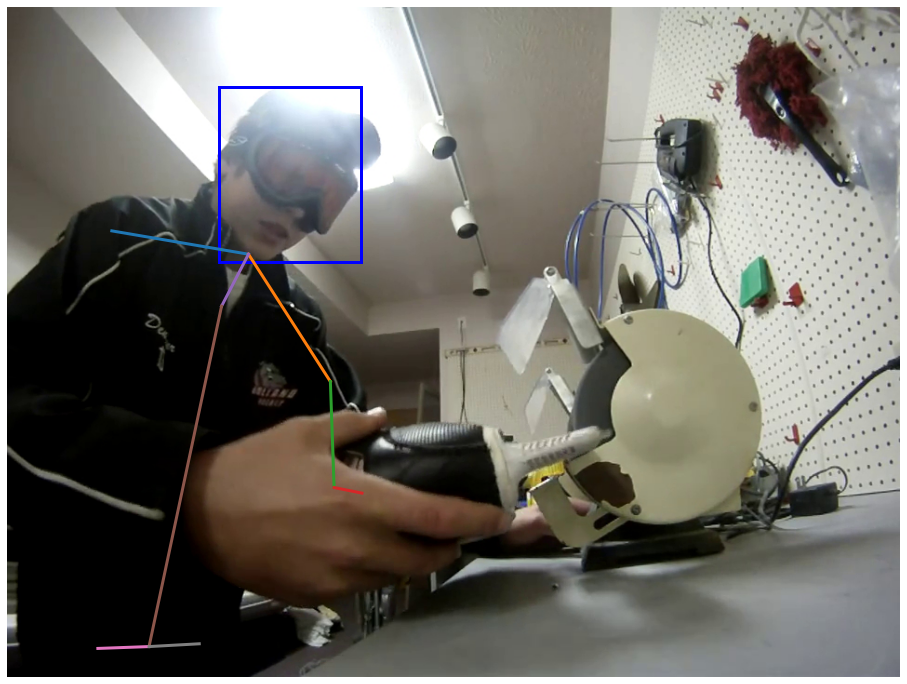

In [7]:
for i in range(10):
    plot_skeleton(train[np.random.randint(len(train))])

### Preprocessing

In [83]:
INPUT_SIZE = 256
HEATMAP_SIZE = 64
N_HEATMAPS = 16

def crop_resize_humans(data_dict):
    
    points = data_dict["joint_pos"]
    p_values = [*points.values()]
    head = data_dict["head_rect"]

    x_points = [item[0] for item in p_values]
    y_points = [item[1] for item in p_values]

    img = Image.open(f'{IMG_FOLDER}/{data_dict["filename"]}')
    x_shape, y_shape = img.size

    head_size = head[2] - head[0]

    y_max = int(min(max(y_points) + head_size, y_shape))
    y_min = int(max(min(y_points) - head_size, 0))
    x_max = int(min(max(x_points) + head_size, x_shape))
    x_min = int(max(min(x_points) - head_size, 0))

    crop_img = img.crop((x_min, y_min, x_max, y_max))

    resized_img = crop_img.resize((INPUT_SIZE,INPUT_SIZE))

    translation =  np.array([x_min, y_min])

    new_points = (np.array(p_values) - translation)*resized_img.size/crop_img.size
    n_p = {}
    discard_joint = ([-1, -1] - translation) * resized_img.size/crop_img.size
    for k, v in zip(points.keys(), new_points):
        if v[0] == discard_joint[0] or v[1] == discard_joint[1]:
            n_p[k] = [-1,-1]
        else:
            n_p[k] = v

    new_head = np.concatenate(((np.array(head[:2]) - translation)*resized_img.size/crop_img.size, \
                               (np.array(head[2:]) - translation)*resized_img.size/crop_img.size))
        
    return {'img': resized_img, 'head_rect': new_head, 'joint_pos': n_p}

In [77]:
d = crop_resize_humans(train[25555])

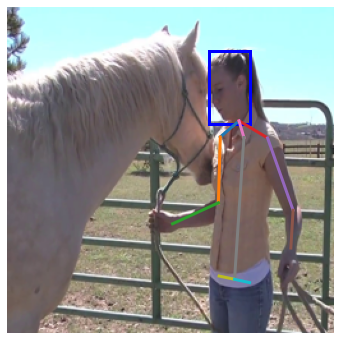

In [78]:
plot_skeleton(d)

### Heatmap generation

The heatmaps for those joints that are not annotated are zeros, according to [Stacked Hourglass Networks for Human Pose Estimation](https://arxiv.org/abs/1603.06937).

In [11]:
# Code adapted from https://github.com/ildoonet/tf-pose-estimation/blob/master/tf_pose/pose_dataset.py
# It creates a 2D gaussian (with standard deviation of sigma px) around center
def put_heatmap(heatmap, center, sigma):
        center_x, center_y = center
        height, width = heatmap.shape

        th = 4.6052
        delta = np.sqrt(th * 2)

        x0 = int(max(0, center_x - delta * sigma))
        y0 = int(max(0, center_y - delta * sigma))

        x1 = int(min(width, center_x + delta * sigma))
        y1 = int(min(height, center_y + delta * sigma))

        for y in range(y0, y1):
            for x in range(x0, x1):
                d = (x - center_x) ** 2 + (y - center_y) ** 2
                exp = d / 2.0 / sigma / sigma
                if exp > th:
                    continue
                heatmap[y][x] = max(heatmap[y][x], np.exp(-exp))
                heatmap[y][x] = min(heatmap[y][x], 1.0)

In [95]:
def generate_heatmaps(data_dict):
    h = np.zeros((N_HEATMAPS,HEATMAP_SIZE,HEATMAP_SIZE))
    for j in sorted(data_dict['joint_pos'].keys()):
        if data_dict['joint_pos'][j][0] != -1 and data_dict['joint_pos'][j][1] != -1:
            put_heatmap(h[j], np.array(data_dict['joint_pos'][j]) // 4, 1)
    return h

In [110]:
def plot_img_with_heatmaps(image, heatmaps):
    plt.figure(figsize=(16,8))
    rows = 3
    cols = len(heatmaps) // 3 + 1
    for i in range(heatmaps.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        c_h = Image.fromarray(np.array(heatmaps[i] * 255, dtype=np.uint8), mode='L').resize(size=(INPUT_SIZE,INPUT_SIZE), resample=0)
        plt.imshow(c_h, alpha=0.8)
        plt.axis('off')

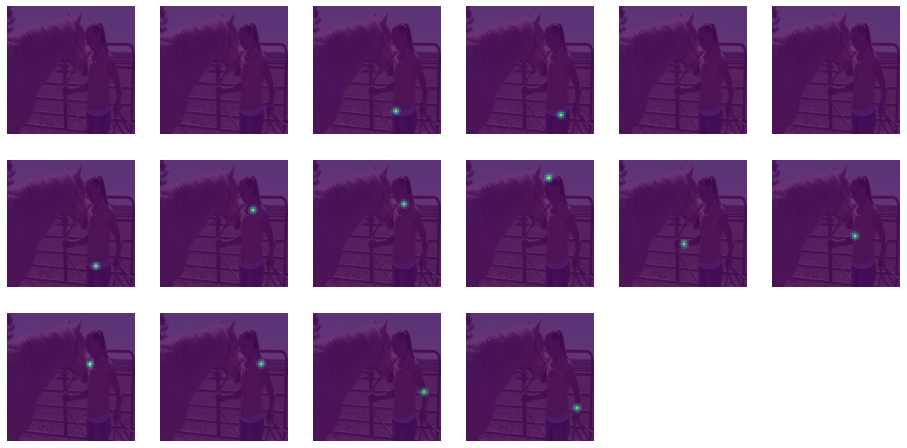

In [111]:
plot_img_with_heatmaps(d['img'], generate_heatmaps(d))

#### Let's zoom into the heatmap points

__NOTE__: Do not run this cell, as the output is highly dependant on the input image.

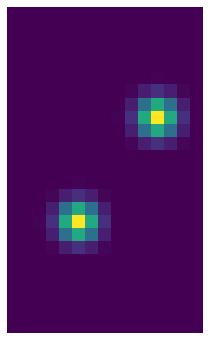

In [26]:
plt.figure(figsize=(6,6))
plt.imshow((h[11] + h[12])[25:50,40:55])
_ = plt.axis('off')

### Build Keras-Like Dataset

In [105]:
class MPI_Dataset(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set
        self.batch_size = batch_size
    
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def __getitem__(self, idx):
        raw_batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.zeros((self.batch_size, INPUT_SIZE, INPUT_SIZE, 3), dtype=np.uint8)
        batch_y = np.zeros((self.batch_size, N_HEATMAPS, HEATMAP_SIZE, HEATMAP_SIZE), dtype=np.float32)
        
        for i, d in enumerate(raw_batch_x):
            crop = crop_resize_humans(d)
            batch_x[i,:,:,:] = crop['img']
            batch_y[i,:,:,:] = generate_heatmaps(crop)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.x)

In [106]:
train_data = MPI_Dataset(train, 24)

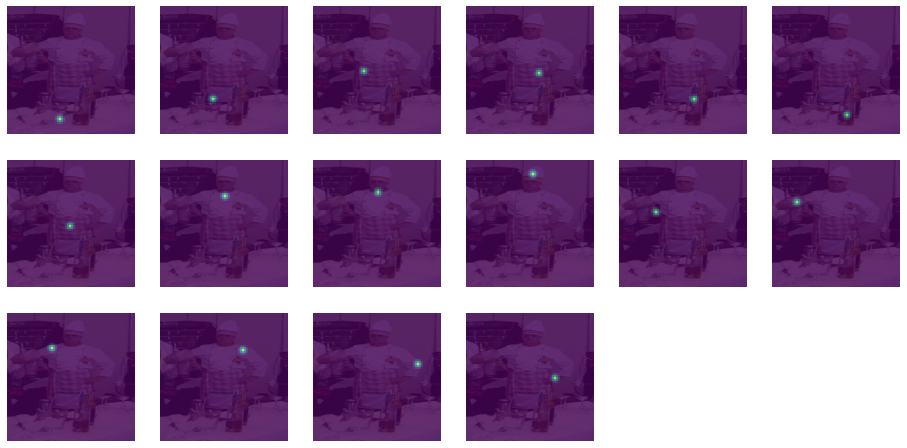

In [112]:
example_x, example_y = train_data.__getitem__(1)
plot_img_with_heatmaps(example_x[0], example_y[0])

## Build the CNN architecture

![Hourglass architecture](res/architecture.png)
Hourglass architecture, each box is formed by a residual module.

![Residual Module](res/residual.png)
Residual Module, we firs apply a 1x1 kernel convolution of half the filters, then a 3x3 kernel convolution to half the filters and  then a 1x1 kernel convolution with all the filters. Finally we add the inputs previous to the residual module and the output of the residual module channel by channel (and apply a non-linearity).

![Intermediate Supervision](res/intermediate_supervision.png)
Intermediate Supervision visualization, the network splits and produces a set of heatmaps (outlined in blue) where a loss can be applied. A 1x1 convolution remaps the heatmaps to match the number of channels of the intermediate features. These are added together along with the features from the preceding hourglass.

Images taken from [Stacked Hourglass Networks for Human Pose Estimation](https://arxiv.org/abs/1603.06937).

As it can be seen in the images, the CNN topology is non-linear, so we replace Keras [Sequential API](https://keras.io/guides/sequential_model/) for Keras [Functional API](https://keras.io/guides/functional_api/).

Following code has been witten based on [this](https://github.com/princeton-vl/pose-hg-train), which is the original paper's code in Lua.

In [80]:
def residual_module(inputs, filters=None):
    if filters == None:
        raise ValueError('Named Parameter filters doesn not have a value.')
    
    x = BatchNormalization()(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=1,
        padding='same')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same')(x)
    
    return Add()([inputs, x])

In [81]:
def hourglass(inputs, n, filters):
    up = residual_module(inputs, filters=filters)
    up = residual_module(up, filters=filters)
    
    low = MaxPool2D(pool_size=2, strides=2)(inputs)
    low = residual_module(low, filters=filters)
    
    if n > 1:
        low2 = hourglass(low1, n - 1, filters)
    else:
        low2 = residual_module(low, filters=filters)
    
    up2 = UpSampling2D(size=2, interpolation='nearest')
    
    return Add()([up, up2])

In [78]:
inp = Input(shape=(256,256,3))
x = Conv2D(
    filters=64, 
    kernel_size=7, 
    strides=2, 
    padding='same')(inp)

x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(
    filters=128, 
    kernel_size=1, 
    strides=1, 
    padding='same')(x)

x = residual_module(x, filters=128)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = residual_module(x, filters=128)
x = Conv2D(
    filters=256, 
    kernel_size=1, 
    strides=1, 
    padding='same')(x)

x = residual_module(x, filters=256)

## TODO: unroll hourglass stacks

m=tf.keras.Model(inp, x)

In [79]:
m.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128, 128, 64) 256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
re_lu_7 (ReLU)                  (None, 128, 128, 64) 0           batch_normalization_3[0][0]      
____________________________________________________________________________________________